# OCR Tesseract Setup

In [1]:
!sudo apt install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,330 kB of archives.
After this operation, 16.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Get:4 http://archive.ubuntu.

In [5]:
!pip install pytesseract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Setup

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive/

In [8]:
import os

In [9]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [10]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

In [11]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [12]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

In [13]:
if os.name=='nt':
    !pip install wget
    import wget

In [14]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

Cloning into 'Tensorflow/models'...
remote: Enumerating objects: 74478, done.
remote: Counting objects: 100% (498/498), done.
remote: Compressing objects: 100% (265/265), done.
remote: Total 74478 (delta 265), reused 438 (delta 223), pack-reused 73980
Receiving objects: 100% (74478/74478), 580.38 MiB | 32.54 MiB/s, done.
Resolving deltas: 100% (52731/52731), done.


In [15]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install
    !cd Tensorflow/models/research/slim && pip install -e . 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/Tensorflow/models/research
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 10.3 MB 8.5 MB/s 
     |███████████████████████████████

# Load Checkpoint

In [16]:
import object_detection

In [17]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [18]:
# Unzip models from drive to env
arcive_models = '/mydrive/TFOD/models.tar.gz'
!tar -zxvf {arcive_models}

Tensorflow/workspace/models/my_ssd_mobnet/
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-1.index
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-1.data-00000-of-00001
Tensorflow/workspace/models/my_ssd_mobnet/train/
Tensorflow/workspace/models/my_ssd_mobnet/train/events.out.tfevents.1653556328.842d1caed888.420.0.v2
Tensorflow/workspace/models/my_ssd_mobnet/eval/
Tensorflow/workspace/models/my_ssd_mobnet/eval/events.out.tfevents.1653556631.842d1caed888.723.0.v2
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-2.data-00000-of-00001
Tensorflow/workspace/models/my_ssd_mobnet/ckpt-3.index
Tensorflow/workspace/models/my_ssd_mobnet/export/
Tensorflow/workspace/models/my_ssd_mobnet/export/pipeline.config
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/variables/
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/variables/variables.data-00000-of-00001
Tensorflow/workspace/models/my_ssd_mobnet/export/saved_model/

In [30]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-3')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

In [21]:
!pip install opencv-python-headless==4.1.2.30

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 90.9 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [22]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
# copy label_map models from drive to env

!cp -r /content/gdrive/MyDrive/TFOD/KAYECE-3/label_map.pbtxt /content/Tensorflow/workspace/annotations

In [31]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [1446]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', 'ktp-002.jpg')

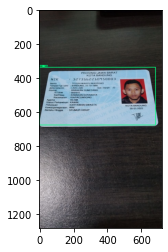

In [1447]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# Image Pre-processing

In [833]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import ipywidgets as widgets
import pytesseract

In [1448]:
detection_threshold = 0.7

In [1449]:
image = image_np_with_detections
scores = list(filter(lambda x: x> detection_threshold, detections['detection_scores']))
boxes = detections['detection_boxes'][:len(scores)]
classes = detections['detection_classes'][:len(scores)]

In [1450]:
width = image.shape[1]
height = image.shape[0]

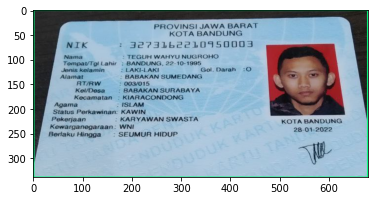

In [1451]:
# Apply ROI filtering and OCR
for idx, box in enumerate(boxes):
    # print(box)
    roi = box*[height, width, height, width]
    # print(roi)
    region = image[int(roi[0]):int(roi[2]),int(roi[1]):int(roi[3])]
    im = region.copy()
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))

## Method 1

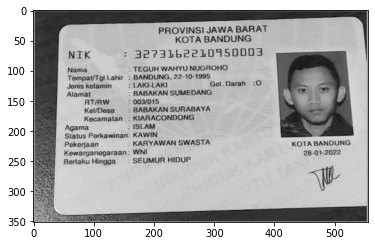

In [ ]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

In [ ]:
# Performing OTSU threshold
ret, thresh1 = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

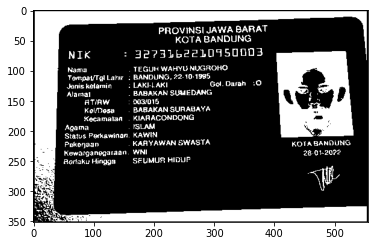

In [ ]:
plt.imshow(cv2.cvtColor(thresh1, cv2.COLOR_BGR2RGB))

In [ ]:
# Specify structure shape and kernel size.
# Kernel size increases or decreases the area
# of the rectangle to be detected.
# A smaller value like (10, 10) will detect
# each word instead of a sentence.
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))

In [ ]:
# Applying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)

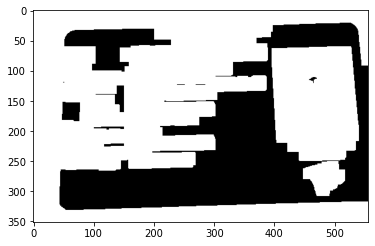

In [ ]:
plt.imshow(cv2.cvtColor(dilation, cv2.COLOR_BGR2RGB))

In [ ]:
# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)

In [ ]:
im1 = im.copy()

In [ ]:
import pytesseract
# Looping through the identified contours
# Then rectangular part is cropped and passed on
# to pytesseract for extracting text from it
# Extracted text is then written into the text file
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
     
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(im1, (x, y), (x + w, y + h), (0, 255, 0), 2)
     
    # Cropping the text block for giving input to OCR
    cropped = im1[y:y + h, x:x + w]
     
    # Apply OCR on the cropped image
    text = pytesseract.image_to_string(cropped, lang="ind")

In [ ]:
for word in text.split("\n"):
  print(word)

NIK :

Nama
TempavTgl Lahir :
Jonis kolamin
Alamat
RTRW
KelDesa

Kecamatan
Agama

Status Perkawinan.
Pekerjaan
Kewarganegaraan
Berlaku Hingga

 

PROVINSI JAWA BARAT
KOTA BANDUNG

32?3152210950003

TEGUH WAHYU NUGROHO
BANDUNG, 22-10-1995

H LAKI-LAKI Gol. Darah :O

BABAKAN SUMEDANG

10031015
: BABAKAN SURABAYA
: KIARACONDONG

ISLAM
KAWIN

KARYAWAN SWASTA KOTA BANDUNG,
WNI 28-01-2022

SEUMUR HIDUP



## Method 2

In [ ]:
from imutils.perspective import four_point_transform
import math
from difflib import SequenceMatcher

In [ ]:
# Load image, grayscale, Gaussian blur, Otsu's threshold

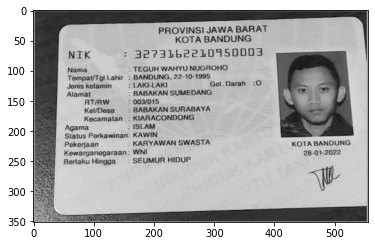

In [ ]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

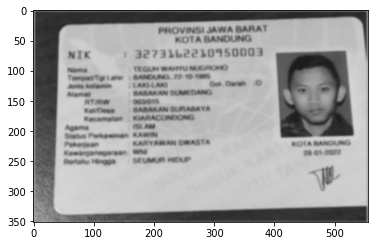

In [ ]:
blur = cv2.GaussianBlur(gray, (7, 7), 0)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

In [ ]:
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

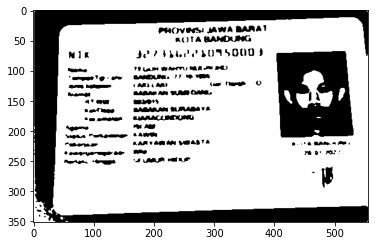

In [ ]:
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

In [ ]:
# Find contours and sort for largest contour
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None

In [ ]:
for c in cnts:
  # Perform contour approximation
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  if len(approx) == 4:
    displayCnt = approx
    break

In [ ]:
# Obtain birds' eye view of image
warped = four_point_transform(im, displayCnt.reshape(4, 2))

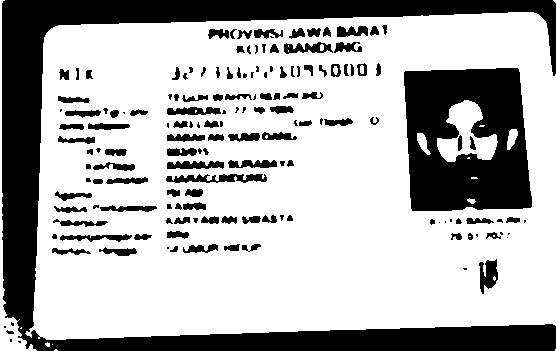

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(thresh)

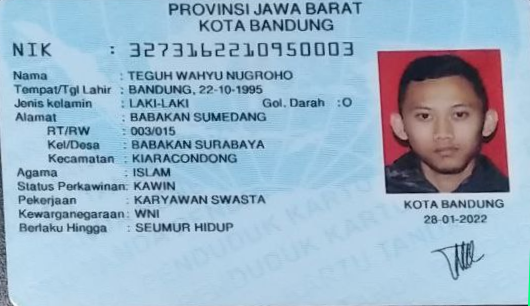

In [ ]:
cv2_imshow(warped)

In [ ]:
# Apply OCR on the cropped image
text = pytesseract.image_to_string(warped, lang="ind")

In [ ]:
for word in text.split("\n"):
  print(word)

NIK 2
Nama

TempatTgi Lahir :
Jenis kolamin — : LAKI-LAKI

Status Perkawinan:
Pekerjaan
Kewarganegaraan
Bertaku Hingga

PROVINSI JAWA BARAT

KOTA BANDUNG
30?3152210950003

TEGUH WAHYU NUGROHO
BANDUNG, 22-10-1905
Gol. Darah :O

KAWIN
KARYAWAN SWASTA

WNI
SEUMUR HIDUP

KOTA BANDUNG
28-01-2022

2.

 



## Method 3 [ Under Development Because Tesseract From Method 1 ]

In [ ]:
# Load iamge, grayscale, adaptive threshold

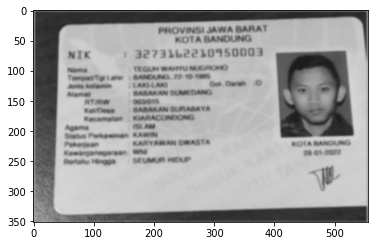

In [ ]:
gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

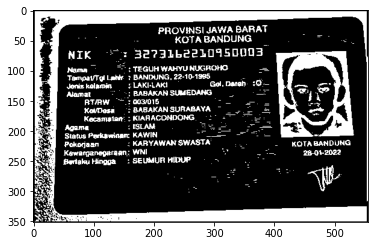

In [ ]:
thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51, 9)
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

In [ ]:
# Fill rectangular contours
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
  cv2.drawContours(thresh, [c], -1, (255, 255, 255), -1)

In [ ]:
# Morph open
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=4)

In [ ]:
im3 = im.copy()

In [ ]:
# Draw rectangles
cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL,
                            cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
  x, y, w, h = cv2.boundingRect(c)
  
  # Drawing a rectangle on copied image
  cv2.rectangle(im3, (x, y), (x + w, y + h), (36, 255, 12), 3)

  # Cropping the text block for giving input to OCR
  crop_img = im3[y: y + h, x: x + w]

  # Apply OCR on the cropped image
  text = pytesseract.image_to_string(cropped, lang="ind")

In [ ]:
for word in text.split("\n"):
  print(word)

NIK :

Nama
TempavTgl Lahir :
Jonis kolamin
Alamat
RTRW
KelDesa

Kecamatan
Agama

Status Perkawinan.
Pekerjaan
Kewarganegaraan
Berlaku Hingga

 

PROVINSI JAWA BARAT
KOTA BANDUNG

32?3152210950003

TEGUH WAHYU NUGROHO
BANDUNG, 22-10-1995

H LAKI-LAKI Gol. Darah :O

BABAKAN SUMEDANG

10031015
: BABAKAN SURABAYA
: KIARACONDONG

ISLAM
KAWIN

KARYAWAN SWASTA KOTA BANDUNG,
WNI 28-01-2022

SEUMUR HIDUP



# Assign Variable To Create Json

In [ ]:
import re

In [ ]:
nik = ''
nama = ''
tempat_lahir = ''
tanggal_lahir = ''
jenis_kelamin = ''
golongan_darah = ''
alamat = ''
rt = ''
rw = ''
kelurahan = ''
kecamatan = ''
agama = ''
status = ''
pekerjaan = ''
kewarganegaraan = ''
berlaku = ''

In [ ]:
# Pre-processing extracted information
for word in text.split("\n"):
  if "”—" in word:
    word = word.replace("”—", ":")
  if "?" in word:
    word = word.replace("?", "7")
  if 'Darah' in word:
    jenis_kelamin = re.search("(LAKI-LAKI|LAKI|LELAKI|PEREMPUAN)", word)[0]
    try:
      golongan_darah = re.search("(O|A|B|AB)", word[-1])[0]
    except:
      golongan_darah = '-'
  if re.match(r'(SEUMUR|HIDUP|SEUMURHIDUP|SEUMUR HIDUP)', word):
    berlaku = "SEUMUR HIDUP"
  if re.match(r'(WNI)', word):
    if word:
      kewarganegaraan = "WNI"
    else:
      kewarganegaraan = "-"    
  print(word)

NIK :

Nama
TempavTgl Lahir :
Jonis kolamin
Alamat
RTRW
KelDesa

Kecamatan
Agama

Status Perkawinan.
Pekerjaan
Kewarganegaraan
Berlaku Hingga

 

PROVINSI JAWA BARAT
KOTA BANDUNG

3273152210950003

TEGUH WAHYU NUGROHO
BANDUNG, 22-10-1995

H LAKI-LAKI Gol. Darah :O

BABAKAN SUMEDANG

10031015
: BABAKAN SURABAYA
: KIARACONDONG

ISLAM
KAWIN

KARYAWAN SWASTA KOTA BANDUNG,
WNI 28-01-2022

SEUMUR HIDUP



In [ ]:
print(agama)

BUDDHA


# Inference TFLite Testing

In [35]:
# Import packages
import os
import argparse
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import sys
import glob
import importlib.util

In [37]:
MODEL_NAME = '/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/'
GRAPH_NAME = '/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/saved_model/detect.tflite'
LABELMAP_NAME = '/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/labelmap.txt'
min_conf_threshold = 0.5

# Get path to current working directory
CWD_PATH = os.getcwd()

# Import TensorFlow libraries
# If tflite_runtime is installed, import interpreter from tflite_runtime, else import from regular tensorflow
# If using Coral Edge TPU, import the load_delegate library
pkg = importlib.util.find_spec('tflite_runtime')
if pkg:
    from tflite_runtime.interpreter import Interpreter
    if False:
        from tflite_runtime.interpreter import load_delegate
else:
    from tensorflow.lite.python.interpreter import Interpreter
    if False:
        from tensorflow.lite.python.interpreter import load_delegate

# If using Edge TPU, assign filename for Edge TPU model
if True:
    # If user has specified the name of the .tflite file, use that name, otherwise use default 'edgetpu.tflite'
    GRAPH_NAME == 'detect__with_metadata.tflite'

# Path to .tflite file, which contains the model that is used for object detection
PATH_TO_CKPT = os.path.join(CWD_PATH,MODEL_NAME,GRAPH_NAME)

# Path to label map file
PATH_TO_LABELS = os.path.join(CWD_PATH,MODEL_NAME,LABELMAP_NAME)

# Load the label map
with open(PATH_TO_LABELS, 'r') as f:
    labels = [line.strip() for line in f.readlines()]

# Have to do a weird fix for label map if using the COCO "starter model" from
# https://www.tensorflow.org/lite/models/object_detection/overview
# First label is '???', which has to be removed.
if labels[0] == '???':
    del(labels[0])

# Load the Tensorflow Lite model.
# If using Edge TPU, use special load_delegate argument
if True:
  interpreter = Interpreter(model_path=PATH_TO_CKPT)

interpreter.allocate_tensors()


In [38]:
print(GRAPH_NAME)

/content/Tensorflow/workspace/models/my_ssd_mobnet/tfliteexport/saved_model/detect.tflite


In [39]:
# Parse input image name and directory. 
IM_NAME = '/content/Tensorflow/workspace/images/test/test2.jpg'
IM_DIR = '/content/Tensorflow/workspace/images/test'

In [40]:
# Define path to images and grab all image filenames
if IM_DIR:
    PATH_TO_IMAGES = os.path.join(CWD_PATH,IM_DIR)
    print(PATH_TO_IMAGES)
    images = glob.glob(PATH_TO_IMAGES + '/*')
    print(images)

elif IM_NAME:
    PATH_TO_IMAGES = os.path.join(CWD_PATH,IM_NAME)
    print(PATH_TO_IMAGES)
    images = glob.glob(PATH_TO_IMAGES)
    print(images)

/content/Tensorflow/workspace/images/test
['/content/Tensorflow/workspace/images/test/ktp-001.jpg']


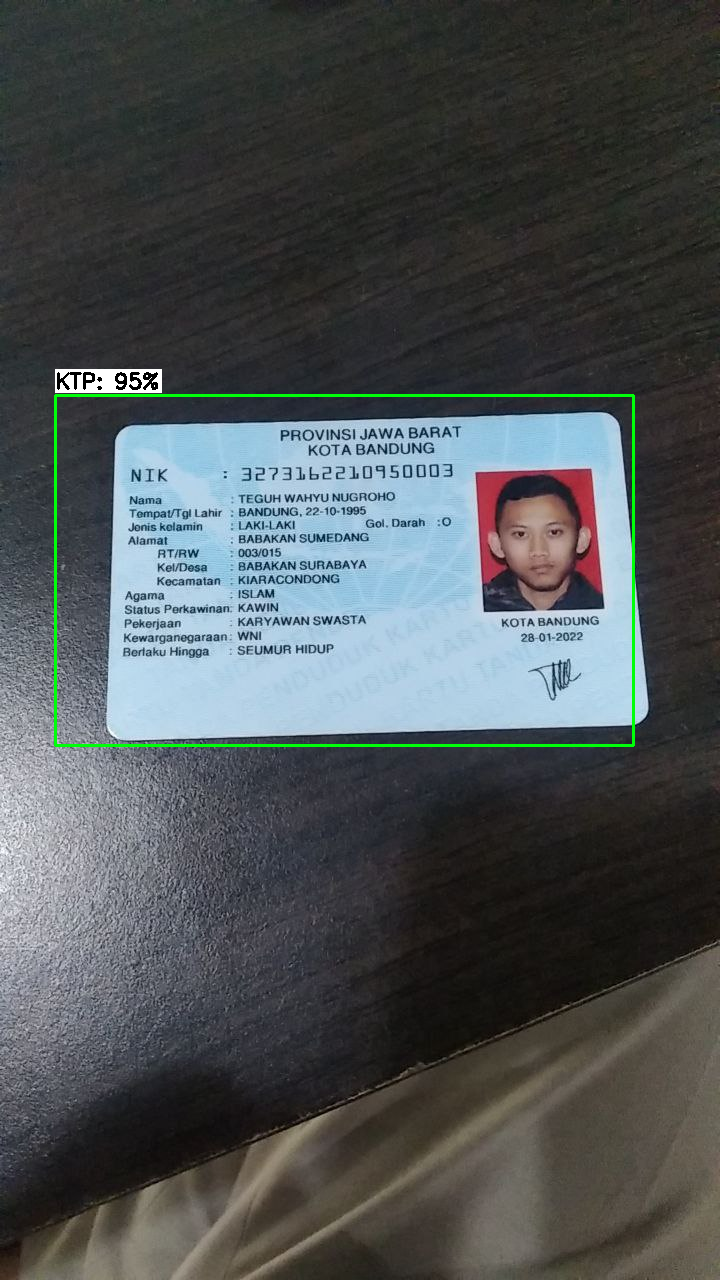

In [41]:
# Get model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

floating_model = (input_details[0]['dtype'] == np.float32)

input_mean = 127.5
input_std = 127.5

# Check output layer name to determine if this model was created with TF2 or TF1,
# because outputs are ordered differently for TF2 and TF1 models
outname = output_details[0]['name']

if ('StatefulPartitionedCall' in outname): # This is a TF2 model
    boxes_idx, classes_idx, scores_idx = 1, 3, 0
else: # This is a TF1 model
    boxes_idx, classes_idx, scores_idx = 0, 1, 2

# Loop over every image and perform detection
for image_path in images:

    # Load image and resize to expected shape [1xHxWx3]
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    imH, imW, _ = image.shape 
    image_resized = cv2.resize(image_rgb, (width, height))
    input_data = np.expand_dims(image_resized, axis=0)

    # Normalize pixel values if using a floating model (i.e. if model is non-quantized)
    if floating_model:
        input_data = (np.float32(input_data) - input_mean) / input_std

    # Perform the actual detection by running the model with the image as input
    interpreter.set_tensor(input_details[0]['index'],input_data)
    interpreter.invoke()

    # Retrieve detection results
    boxes = interpreter.get_tensor(output_details[boxes_idx]['index'])[0] # Bounding box coordinates of detected objects
    classes = interpreter.get_tensor(output_details[classes_idx]['index'])[0] # Class index of detected objects
    scores = interpreter.get_tensor(output_details[scores_idx]['index'])[0] # Confidence of detected objects

    # Loop over all detections and draw detection box if confidence is above minimum threshold
    for i in range(len(scores)):
        if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

            # Get bounding box coordinates and draw box
            # Interpreter can return coordinates that are outside of image dimensions, need to force them to be within image using max() and min()
            ymin = int(max(1,(boxes[i][0] * imH)))
            xmin = int(max(1,(boxes[i][1] * imW)))
            ymax = int(min(imH,(boxes[i][2] * imH)))
            xmax = int(min(imW,(boxes[i][3] * imW)))
            
            cv2.rectangle(image, (xmin,ymin), (xmax,ymax), (10, 255, 0), 2)

            # Draw label
            object_name = labels[int(classes[i])] # Look up object name from "labels" array using class index
            label = '%s: %d%%' % (object_name, int(scores[i]*100)) # Example: 'person: 72%'
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.7, 2) # Get font size
            label_ymin = max(ymin, labelSize[1] + 10) # Make sure not to draw label too close to top of window
            cv2.rectangle(image, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), (255, 255, 255), cv2.FILLED) # Draw white box to put label text in
            cv2.putText(image, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2) # Draw label text

    # All the results have been drawn on the image, now display the image
    cv2_imshow(image)

# Testing Production Pytesseract

In [264]:
from imutils.perspective import four_point_transform

In [628]:
im2 = im.copy()

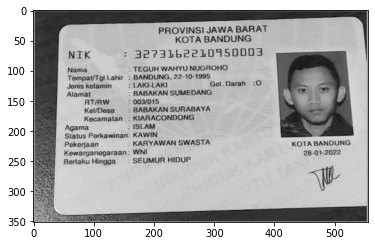

In [128]:
# Method 4
gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

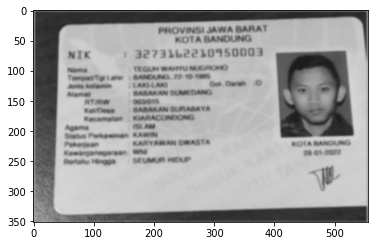

In [129]:
blur = cv2.GaussianBlur(gray, (7, 7), 0)
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

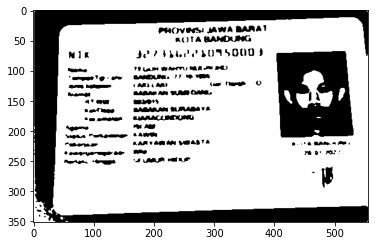

In [130]:
thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
plt.imshow(cv2.cvtColor(thresh, cv2.COLOR_BGR2RGB))

In [131]:
# Find contours and sort for largest contour
cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None

In [132]:
for c in cnts:
  # Perform contour approximation
  peri = cv2.arcLength(c, True)
  approx = cv2.approxPolyDP(c, 0.02 * peri, True)
  if len(approx) == 4:
    displayCnt = approx
    break

In [133]:
# Obtain birds' eye view of image
warped = four_point_transform(im2, displayCnt.reshape(4, 2))

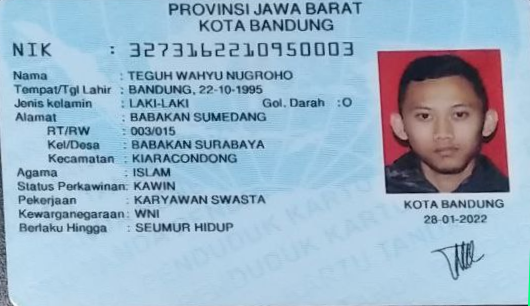

In [134]:
from google.colab.patches import cv2_imshow
cv2_imshow(warped)

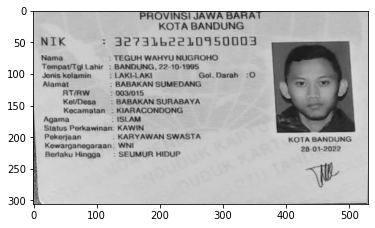

In [167]:
# Method 1
grey = cv2.cvtColor(warped, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(grey, cv2.COLOR_BGR2RGB))

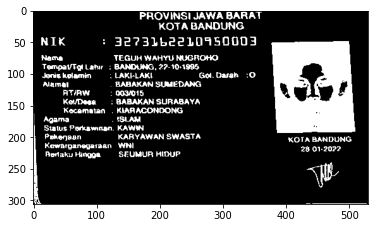

In [169]:
# Performing OTSU threshold
ret, thresh1 = cv2.threshold(grey, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
plt.imshow(cv2.cvtColor(thresh1, cv2.COLOR_BGR2RGB))

In [561]:
# Specify structure shape and kernel size.
# Kernel size increases or decreases the area
# of the rectangle to be detected.
# A smaller value like (10, 10) will detect
# each word instead of a sentence.
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))

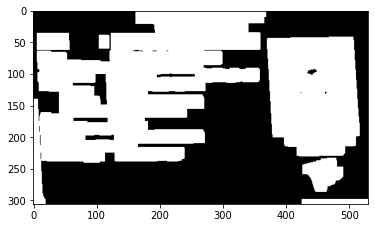

In [562]:
# Applying dilation on the threshold image
dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1)
plt.imshow(cv2.cvtColor(dilation, cv2.COLOR_BGR2RGB))

In [563]:
# Finding contours
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL,
                                                 cv2.CHAIN_APPROX_NONE)

In [564]:
im4 = im2.copy()

In [565]:
# Looping through the identified contours
# Then rectangular part is cropped and passed on
# to pytesseract for extracting text from it
# Extracted text is then written into the text file
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
     
    # Drawing a rectangle on copied image
    rect = cv2.rectangle(im4, (x, y), (x + w, y + h), (0, 255, 0), 2)
     
    # Cropping the text block for giving input to OCR
    cropped = im4[y:y + h, x:x + w]
     
    # Apply OCR on the cropped image
    text = pytesseract.image_to_string(cropped, lang="ind")

In [566]:
for word in text.split("\n"):
  print(word)

 
 

NIK z
Nama

Tempat/Tgl Lahir :
H LAKI-LAKI Gol. Darah

Jonis kolamin
Mamat
RTRW
KelDesa
Kecamatan
Agama
Status Perkawinan.
Pekerjaan
Kewarganegaraan
Berlaku Hingga

 

PROVINSI JAWA BAR
KOTA BANDUNG

327316221095000

TEGUH WAHYU NUGROHO
BANDUNG, 22-10-1905

BABAKAN SUMEDANG
003/015

BABAKAN SURABAYA
KIARACONDONG,
ISLAM

KAWIN

KARYAWAN SWASTA
WNI

SEUMUR HIDUP



In [265]:
import re

In [266]:
nik = ''
nama = ''
tempat_lahir = ''
tanggal_lahir = ''
jenis_kelamin = ''
golongan_darah = ''
alamat = ''
rt = ''
rw = ''
kelurahan = ''
kecamatan = ''
agama = ''
status = ''
pekerjaan = ''
kewarganegaraan = ''
berlaku = ''

In [307]:
# Pre-processing extracted information
for word in text.split("\n"):
  print(word)
  # print(len(word))

 
 

NIK z
Nama

Tempat/Tgl Lahir :
H LAKI-LAKI Gol. Darah

Jonis kolamin
Mamat
RTRW
KelDesa
Kecamatan
Agama
Status Perkawinan.
Pekerjaan
Kewarganegaraan
Berlaku Hingga

 

PROVINSI JAWA BAR
KOTA BANDUNG

327316221095000

TEGUH WAHYU NUGROHO
BANDUNG, 22-10-1905

BABAKAN SUMEDANG
003/015

BABAKAN SURABAYA
KIARACONDONG,
ISLAM

KAWIN

KARYAWAN SWASTA
WNI

SEUMUR HIDUP



In [301]:
# Pre-processing extracted information
for word in text.split("\n"):
  if "”—" in word:
    word = word.replace("”—", ":")
  if "?" in word:
    word = word.replace("?", "7")
  if 'Darah' in word:
    jenis_kelamin = re.search("(LAKI-LAKI|LAKI|LELAKI|PEREMPUAN)", word)[0]
    try:
      golongan_darah = re.search("(O|A|B|AB)", word[-1])[0]
    except:
      golongan_darah = '-'
  if re.match(r'(SEUMUR|HIDUP|SEUMURHIDUP|SEUMUR HIDUP)', word):
    berlaku = "SEUMUR HIDUP"
  if re.match(r'(WNI)', word):
    if word:
      kewarganegaraan = "WNI"
    else:
      kewarganegaraan = "-"    
  print(word)

 
 

NIK z
Nama

Tempat/Tgl Lahir :
H LAKI-LAKI Gol. Darah

Jonis kolamin
Mamat
RTRW
KelDesa
Kecamatan
Agama
Status Perkawinan.
Pekerjaan
Kewarganegaraan
Berlaku Hingga

 

PROVINSI JAWA BAR
KOTA BANDUNG

327316221095000

TEGUH WAHYU NUGROHO
BANDUNG, 22-10-1905

BABAKAN SUMEDANG
003/015

BABAKAN SURABAYA
KIARACONDONG,
ISLAM

KAWIN

KARYAWAN SWASTA
WNI

SEUMUR HIDUP



# EasyOCR

In [567]:
!pip install easyocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 70.8 MB 11 kB/s 


In [568]:
import easyocr

In [630]:
reader = easyocr.Reader(['id'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [678]:
ocr_result = reader.readtext(warped, detail=1)

In [679]:
ocr_result

[([[165, 0], [365, 0], [365, 19], [165, 19]],
  'PROVINSI JAWA BARAT',
  0.7311343054194186),
 ([[195, 15], [335, 15], [335, 35], [195, 35]],
  'KOTA BANDUNG',
  0.9998589692387024),
 ([[9, 39], [55, 39], [55, 59], [9, 59]], 'NIK', 0.9994151436885633),
 ([[125, 35], [358, 35], [358, 63], [125, 63]],
  '3273162210950003',
  0.7773990825797847),
 ([[11, 69], [51, 69], [51, 83], [11, 83]], 'Nama', 0.9691547155380249),
 ([[127, 69], [295, 69], [295, 83], [127, 83]],
  'TEGUH WAHYU NUGnOHO',
  0.7763277344305799),
 ([[13, 83], [115, 83], [115, 99], [13, 99]],
  'TompauTol Lahir',
  0.3058673682209738),
 ([[127, 83], [265, 83], [265, 97], [127, 97]],
  'BANDUNG. 22-101995',
  0.6239505715508886),
 ([[13, 97], [95, 97], [95, 111], [13, 111]],
  'Jonis kolamin',
  0.5854689680065093),
 ([[127, 97], [193, 97], [193, 111], [127, 111]],
  'LAKI-LAKI',
  0.4546336926143825),
 ([[261, 97], [327, 97], [327, 111], [261, 111]],
  'Gol. Darah',
  0.6834106769890722),
 ([[13, 111], [61, 111], [61, 125],

In [680]:
provinsi = ''
kota = ''
nik = ''
nama = ''
ttl = ''
jk = ''
alamat = ''
rtrw = ''
kelurahan = ''
agama = ''
kecamatan = ''
status = ''
pekerjaan = ''
kewarganegaraan = ''
card_type = ''

In [681]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [687]:
for key, value in enumerate(ocr_result):
  
  text = value[1]
  if similar("PROVINSI", text.split(' ')[0]) > 0.7:
    provinsi = text
  if similar("KOTA", text.split(' ')[0]) > 0.7 or similar("KABUPATEN", text.split(' ')[0]) > 0.7:
    kota = text
  if similar("NIK", text) > 0.7:
    nik_val = ocr_result[key + 1][1]
    if nik_val.isnumeric():
      nik = nik_val
  if similar("Nama", text) > 0.7:
    nama_ = ocr_result[key + 1][1]
  if similar("Tempat/Tgl lahir", text) > 0.7:
    if re.search(r'\d', ocr_result[key + 1][1]):
      ttl = ocr_result[key + 1][1]
  if similar("Jenis Kelamin", text) > 0.7:
    jk = ocr_result[key + 1][1]
  if similar("Alamat", text) > 0.8:
    alamat = ocr_result[key + 1][1]
  # if similar("RT/RW", text) > 0.7:
    # rtrw = ocr_result[key + 1][1]
  if similar("Kel/Desa", text) > 0.7:
    kelurahan = ocr_result[key + 1][1]
  if similar("Kecamatan", text) > 0.7:
    kecamatan = ocr_result[key + 1][1]
  if similar("Agama", text) > 0.8:
    agama = ocr_result[key + 1][1]
  if similar("Status Perkawinan", text) > 0.7:
    status = ocr_result[key + 1][1]
  if similar("Pekerjaan", text) > 0.7:
    pekerjaan = ocr_result[key + 1][1]
  if similar("Kewarganegaraan", text) > 0.7:
    kewarganegaraan = ocr_result[key + 1][1]
  if similar("Berlaku Hingga", text) > 0.6:
    berlaku = ocr_result[key + 1][1]

In [689]:
print(provinsi)
print(kota)
print(nik)
print(nama)
print(ttl)
print(jk)
print(alamat)
print(rtrw)
print(kelurahan)
print(agama)
print(kecamatan)
print(status)
print(pekerjaan)
print(kewarganegaraan)
print(berlaku)

PROVINSI JAWA BARAT
KOIA BANDUNG
3273162210950003
TEGUH WAHYU NUGnOHO
BANDUNG. 22-101995
LAKI-LAKI


BABAKAN SURABAYA
ISLAM


KARYAWAN SWASTA
WNI
SeuMuR HiduP


# Testing Production EasyOCR

In [1399]:
im6 = im.copy()

## New Method Pre-Processing

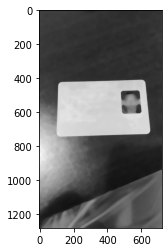

In [1430]:
# Load image, grayscale, Gaussian blur, Otsu's threshold
image = cv2.imread('/content/Tensorflow/workspace/images/test/ktp-001.jpg')
gray = cv2.cvtColor(im6, cv2.COLOR_BGR2GRAY)
dilated_img = cv2.dilate(image[:,:,1], np.ones((7, 7), np.uint8))
bg_img = cv2.medianBlur(dilated_img, 21)
plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))

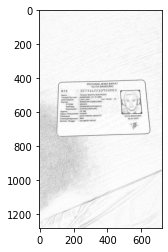

In [1431]:
#--- finding absolute difference to preserve edges ---
diff_img = 255 - cv2.absdiff(image[:,:,1], bg_img)
plt.imshow(cv2.cvtColor(diff_img, cv2.COLOR_BGR2RGB))

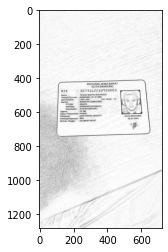

In [1432]:
#--- normalizing between 0 to 255 ---
norm_img = cv2.normalize(diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
plt.imshow(cv2.cvtColor(norm_img, cv2.COLOR_BGR2RGB))

## EasyOCR Running

In [1445]:
reader = easyocr.Reader(['id'], gpu=False)

Using CPU. Note: This module is much faster with a GPU.


In [1433]:
img = norm_img
result = reader.readtext(img, detail=1)

In [1435]:
result

[([[275, 421], [464, 421], [464, 446], [275, 446]],
  'PROVINSI JAWA BARAT',
  0.8394647714815711),
 ([[304, 436], [438, 436], [438, 460], [304, 460]],
  'KOTA BANDUNG',
  0.9952504531008775),
 ([[127, 465], [171, 465], [171, 485], [127, 485]], 'NIK', 0.9992015979093753),
 ([[235, 457], [456, 457], [456, 486], [235, 486]],
  '3273162210950003',
  0.9353084698458639),
 ([[127, 495], [165, 495], [165, 507], [127, 507]],
  'Nama',
  0.9990414977073669),
 ([[237, 489], [399, 489], [399, 507], [237, 507]],
  'TEGUH WAHYU NUGROHO',
  0.9736999811630443),
 ([[129, 507], [225, 507], [225, 523], [129, 523]],
  'TompalTol Lahir',
  0.4322338849480756),
 ([[237, 505], [369, 505], [369, 519], [237, 519]],
  'BANDUNG , ?2-10-1995',
  0.6082288838766531),
 ([[127, 521], [205, 521], [205, 535], [127, 535]],
  'Jonis kolamin',
  0.9898258752140874),
 ([[237, 519], [299, 519], [299, 533], [237, 533]],
  'LAKI-LAKI',
  0.9578021365067827),
 ([[365, 517], [429, 517], [429, 531], [365, 531]],
  'Gol . Dar

## Matching Value From Result To Variable

In [1436]:
provinsi = ''
kota = ''
nik = ''
nama = ''
ttl = ''
jk = ''
alamat = ''
rtrw = ''
kelurahan = ''
agama = ''
kecamatan = ''
status = ''
pekerjaan = ''
kewarganegaraan = ''
card_type = ''

### Result For Method Matching Value, We Use SequenceMathcer To Detect Similarity Word

In [1437]:
from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [1438]:
# Detect CardType
for key, value in enumerate(result):
  text = value[1]

  if similar("Berlaku Hingga", text) > 0.6:
    card_type = 'KTP'
    break
  
  if similar("Seumur HIDUP", text) > 0.6:
    card_type = 'KTP'
    break

  if similar("SURAT IZIN MENGEMUDI", text) > 0.7:
    card_type = 'SIM'
    break
  
  if similar("KARTU TANDA MAHASISWA", text) > 0.7:
    card_type = 'KTM'
    break

In [1439]:
print(card_type)

KTP


In [1441]:
for key, value in enumerate(result):
  
  text = value[1]
  if similar("PROVINSI", text.split(' ')[0]) > 0.7:
    provinsi = text
  if similar("KOTA", text.split(' ')[0]) > 0.7 or similar("KABUPATEN", text.split(' ')[0]) > 0.7:
    kota = text
  if similar("NIK", text) > 0.7:
    nik_val = result[key + 1][1]
    if nik_val.isnumeric():
      nik = nik_val
  if similar("Nama", text) > 0.7:
    nama = result[key + 1][1]
  if similar("Tempat/Tgl lahir", text) > 0.7:
    if re.search(r'\d', result[key + 1][1]):
      ttl = result[key + 1][1]
    else:
      ttl = result[key + 1][1] + ' ' + result[key + 2][1]
    if '?' in ttl:
      ttl = ttl.replace('?', '2')
  if similar("Jenis kelamin", text) > 0.7:
    jk = result[key + 1][1]
  if similar("Alamat", text) > 0.8:
    alamat = result[key + 1][1]
  if similar("RT/RW", text) > 0.7:
    rtrw = result[key + 1][1]
  if similar("Kel/Desa", text) > 0.7:
    kelurahan = result[key + 1][1]
  if similar("Kecamatan", text) > 0.7:
    kecamatan = result[key + 1][1]
  if similar("Agama", text) > 0.8:
    agama = result[key + 1][1]
  if similar("Status Perkawinan", text) > 0.7:
    status = result[key + 1][1]
  if similar("Pekerjaan", text) > 0.7:
    pekerjaan = result[key + 1][1]
  if similar("Kewarganegaraan", text) > 0.7:
    kewarganegaraan = result[key + 1][1]
  if similar("Berlaku Hingga", text) > 0.6:
    berlaku = result[key + 1][1]

In [1442]:
print(provinsi)
print(kota)
print(nik)
print(nama)
print(ttl)
print(jk)
print(alamat)
print(rtrw)
print(kelurahan)
print(kecamatan)
print(agama)
print(status)
print(pekerjaan)
print(kewarganegaraan)

PROVINSI JAWA BARAT
KOTA BANDUNG
3273162210950003
TEGUH WAHYU NUGROHO
BANDUNG , 22-10-1995
LAKI-LAKI
BABAKAN SUMEDANG

BABAKAN SURABAYA
KIARACONDONG
ISLAM
Pekerjaan
KARYAWAN SWASTA
WNI


## Create a Sample Json To Deployment 

In [1443]:
import json

a = {
      "card_type": card_type,
      "data": {
          'provinsi': provinsi,
          'kota': kota,
          'nik': nik,
          'nama': nama,
          'ttl': ttl,
          'jk': jk,
          'alamat': alamat,
          'rt/rw': rtrw,
          'kel': kelurahan,
          'kec': kecamatan,
          'agama': agama,
          'status': status,
          'pekerjaan': pekerjaan,
          'kewarganegaraan': kewarganegaraan
        }
    }

# conversion to JSON done by dumps() function
b = json.dumps(a)

In [1444]:
print(b)

{"card_type": "KTP", "data": {"provinsi": "PROVINSI JAWA BARAT", "kota": "KOTA BANDUNG", "nik": "3273162210950003", "nama": "TEGUH WAHYU NUGROHO", "ttl": "BANDUNG , 22-10-1995", "jk": "LAKI-LAKI", "alamat": "BABAKAN SUMEDANG", "rt/rw": "", "kel": "BABAKAN SURABAYA", "kec": "KIARACONDONG", "agama": "ISLAM", "status": "Pekerjaan", "pekerjaan": "KARYAWAN SWASTA", "kewarganegaraan": "WNI"}}
